In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import os
from tqdm import tqdm

# Data Processing Libraries 

import pandas as pd 
import numpy as np 


# Feature Engineering Libraries

from sklearn.preprocessing import OneHotEncoder

# Data Visualisation libraries 
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

import cv2
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

SAMPLE_LEN=100

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
train_image_path = '../input/plant-pathology-2021-fgvc8/train_images'
test_image_path = '../input/plant-pathology-2021-fgvc8/test_images'
train_df_path = '../input/plant-pathology-2021-fgvc8/train.csv'
test_df_path = '../input/plant-pathology-2021-fgvc8/sample_submission.csv'

In [5]:
df_train = pd.read_csv(train_df_path)

In [6]:
df_train.head()

,image,labels
0,800113bb65efe69e.jpg,healthy
1,8002cb321f8bfcdf.jpg,scab frog_eye_leaf_spot complex
2,80070f7fb5e2ccaa.jpg,scab
3,80077517781fb94f.jpg,scab
4,800cbf0ff87721f8.jpg,complex


In [7]:
df_train['labels'].value_counts()

labels
scab                               4826
healthy                            4624
frog_eye_leaf_spot                 3181
rust                               1860
complex                            1602
powdery_mildew                     1184
scab frog_eye_leaf_spot             686
scab frog_eye_leaf_spot complex     200
frog_eye_leaf_spot complex          165
rust frog_eye_leaf_spot             120
rust complex                         97
powdery_mildew complex               87
Name: count, dtype: int64

In [8]:
source = df_train['labels'].value_counts()

In [9]:
df_train

,image,labels
0,800113bb65efe69e.jpg,healthy
1,8002cb321f8bfcdf.jpg,scab frog_eye_leaf_spot complex
2,80070f7fb5e2ccaa.jpg,scab
3,80077517781fb94f.jpg,scab
4,800cbf0ff87721f8.jpg,complex
...,...,...
18627,fffb900a92289a33.jpg,healthy
18628,fffc488fa4c0e80c.jpg,scab
18629,fffc94e092a59086.jpg,rust
18630,fffe105cf6808292.jpg,scab frog_eye_leaf_spot


In [10]:
train_image_path

'../input/plant-pathology-2021-fgvc8/train_images'

In [11]:
df_train['label_list'] = df_train['labels'].str.split(' ')

In [13]:
lbls = ['healthy','complex','rust','frog_eye_leaf_spot','powdery_mildew','scab']
for x in lbls:
    df_train[x]=0

In [14]:
def lbl_lgc(col,lbl_list):
    if col in lbl_list:
        res = 1 
    else:
        res = 0
    return res

In [15]:
lbls = ['healthy','complex','rust','frog_eye_leaf_spot','powdery_mildew','scab']

for x in lbls:
    df_train[x] = np.vectorize(lbl_lgc)(x,df_train['label_list'])

In [16]:
df_train

,image,labels,label_list,healthy,complex,rust,frog_eye_leaf_spot,powdery_mildew,scab
0,800113bb65efe69e.jpg,healthy,[healthy],1,0,0,0,0,0
1,8002cb321f8bfcdf.jpg,scab frog_eye_leaf_spot complex,"[scab, frog_eye_leaf_spot, complex]",0,1,0,1,0,1
2,80070f7fb5e2ccaa.jpg,scab,[scab],0,0,0,0,0,1
3,80077517781fb94f.jpg,scab,[scab],0,0,0,0,0,1
4,800cbf0ff87721f8.jpg,complex,[complex],0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...
18627,fffb900a92289a33.jpg,healthy,[healthy],1,0,0,0,0,0
18628,fffc488fa4c0e80c.jpg,scab,[scab],0,0,0,0,0,1
18629,fffc94e092a59086.jpg,rust,[rust],0,0,1,0,0,0
18630,fffe105cf6808292.jpg,scab frog_eye_leaf_spot,"[scab, frog_eye_leaf_spot]",0,0,0,1,0,1


In [17]:
df_train_lbl_onehot = pd.get_dummies(df_train, columns=["labels"], prefix=["LBL"])

In [18]:
df_train_lbl_onehot.columns

Index(['image', 'label_list', 'healthy', 'complex', 'rust',
       'frog_eye_leaf_spot', 'powdery_mildew', 'scab', 'LBL_complex',
       'LBL_frog_eye_leaf_spot', 'LBL_frog_eye_leaf_spot complex',
       'LBL_healthy', 'LBL_powdery_mildew', 'LBL_powdery_mildew complex',
       'LBL_rust', 'LBL_rust complex', 'LBL_rust frog_eye_leaf_spot',
       'LBL_scab', 'LBL_scab frog_eye_leaf_spot',
       'LBL_scab frog_eye_leaf_spot complex'],
      dtype='object')

In [19]:
import tensorflow as tf
def seed_everything():
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1' 
    np.random.seed(hash("improves reproducibility") % 2**32 - 1)
    tf.random.set_seed(hash("by removing stochasticity") % 2**32 - 1)
    
seed_everything()

In [20]:
TRAIN_PATH='/kaggle/input/plant-pathology-2021-fgvc8/train_images'
AUTOTUNE = tf.data.experimental.AUTOTUNE

CONFIG = dict (
    num_labels = 6,
    train_val_split = 0.2,
    img_width = 224,
    img_height = 224,
    batch_size = 32,
    epochs = 10,
    learning_rate = 0.001,
    architecture = "CNN",
    infra = "Kaggle",
    competition = 'plant-pathology',
    #_wandb_kernel = 'ayut'
)

In [21]:
# Encode competition-provided labels 
label_to_id = {
    'healthy': 0,
    'scab': 1,
    'frog_eye_leaf_spot': 2,
    'rust': 3,
    'complex': 4,
    'powdery_mildew': 5
}

id_to_label = {value:key for key, value in label_to_id.items()} 

# Helper fu
def make_path(row):
    return TRAIN_PATH+'/'+row.image

def parse_labels(row):
    label_list = row.labels.split()
    labels = []
    for label in label_list:
        labels.append(str(label_to_id[label]))
    
    return ' '.join(labels)

# Read train.csv file
df = pd.read_csv('../input/plant-pathology-2021-fgvc8/train.csv')
# Get absolute path
df['image'] = df.apply(lambda row: make_path(row), axis=1)
# Parse labels
df['labels'] = df.apply(lambda row: parse_labels(row), axis=1)

# Look at the dataframe
df.head()

,image,labels
0,/kaggle/input/plant-pathology-2021-fgvc8/train...,0
1,/kaggle/input/plant-pathology-2021-fgvc8/train...,1 2 4
2,/kaggle/input/plant-pathology-2021-fgvc8/train...,1
3,/kaggle/input/plant-pathology-2021-fgvc8/train...,1
4,/kaggle/input/plant-pathology-2021-fgvc8/train...,4


In [22]:
from sklearn.model_selection import train_test_split

# 5. Training and validation split

train_df, valid_df = train_test_split(df, test_size=CONFIG['train_val_split'])
print(f'Number of train images: {len(train_df)} and validation images: {len(valid_df)}')

Number of train images: 14905 and validation images: 3727


In [23]:
@tf.function
def decode_image(image):
    # Convert the compressed string to a 3D uint8 tensor
    image = tf.image.decode_jpeg(image, channels=3)
    
    # Normalize image
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    
    # Resize the image to the desired size
    return image

# Data Augmentation

In [24]:
import tensorflow as tf
import cv2
import numpy as np
import tensorflow_addons as tfa  # Import TensorFlow Addons


def data_augment(image, label=None):
    # Retournement aléatoire horizontal
    image = tf.image.random_flip_left_right(image)
    
    # Retournement aléatoire vertical
    image = tf.image.random_flip_up_down(image)
    
    # Rotation aléatoire
    rotation_angle = tf.random.uniform(shape=[], minval=-45, maxval=45)  # Ajustez l'angle de rotation selon vos besoins
    image = tfa.image.rotate(image, rotation_angle)
    
    # Manipulation de la luminosité
    brightness_factor = tf.random.uniform(shape=[], minval=0.3, maxval=0.5)  # Ajustez les valeurs min et max selon vos besoins
    image = tf.image.adjust_brightness(image, brightness_factor)
    
    # Add darkness effect with a certain probability
    if tf.random.uniform([]) < 0.2:  # Adjust the probability as needed
        # Adjust the darkness effect using gamma values
        gamma = tf.random.uniform(shape=[], minval=1.0, maxval=2.5)  # Adjust the range as needed
        image = tf.image.adjust_gamma(image, gamma, gain=1.0)
        
    
    if label is None:
        return image
    else:
        return image, label

In [25]:
@tf.function
def load_image(df_dict, data_augmentation=True):
    # Load image
    image = tf.io.read_file(df_dict['image'])
    image = decode_image(image)
    
    if data_augmentation:
        # Apply data augmentation using data_augment function
        image = data_augment(image)

    # Resize image
    image = tf.image.resize(image, (CONFIG['img_height'], CONFIG['img_width']))
    
    # Parse label
    label = tf.strings.split(df_dict['labels'], sep='')
    label = tf.strings.to_number(label, out_type=tf.int32)
    label = tf.reduce_sum(tf.one_hot(indices=label, depth=CONFIG['num_labels']), axis=0)
    
    return image, label

In [26]:
AUTOTUNE = tf.data.AUTOTUNE

trainloader = tf.data.Dataset.from_tensor_slices(dict(train_df))
validloader = tf.data.Dataset.from_tensor_slices(dict(valid_df))

# Définissez une fonction pour appliquer l'augmentation des données en utilisant map
def load_train_image(x):
    return load_image(x, data_augmentation=True)

def load_valid_image(x):
    return load_image(x, data_augmentation=False)

trainloader = (
    trainloader
    .shuffle(1024)
    .map(load_train_image, num_parallel_calls=AUTOTUNE)
    .batch(CONFIG['batch_size'])
    .prefetch(AUTOTUNE)
)

validloader = (
    validloader
    .map(load_valid_image, num_parallel_calls=AUTOTUNE)
    .batch(CONFIG['batch_size'])
    .prefetch(AUTOTUNE)
)


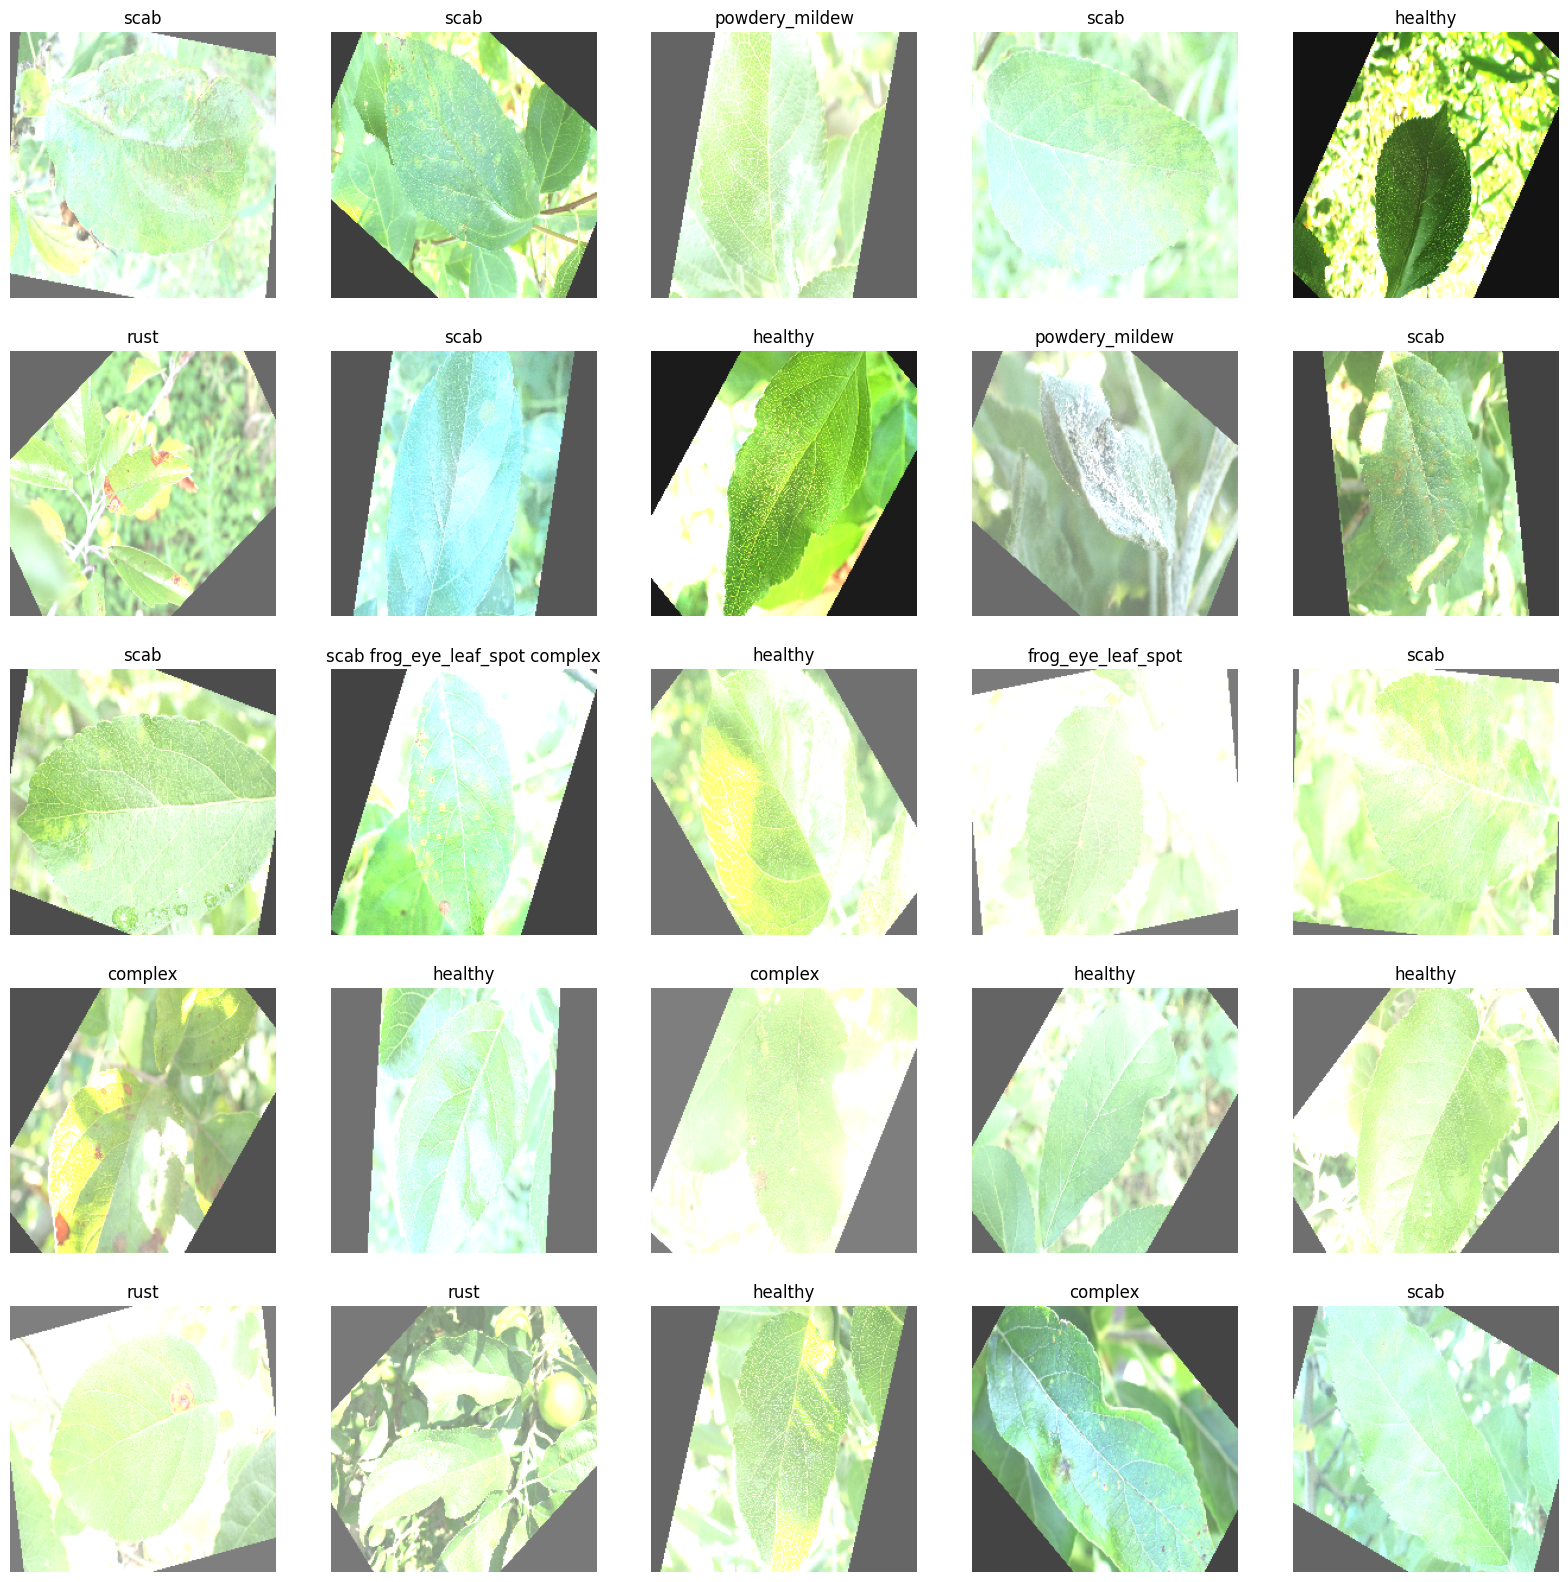

In [27]:
import matplotlib.pyplot as plt

# ...

# Data loader sanity check
def show_batch(data_loader):
    image_batch, label_batch = next(iter(data_loader))
    plt.figure(figsize=(20, 20))
    for n in range(25):
        ax = plt.subplot(5, 5, n + 1)
        plt.imshow(image_batch[n].numpy())
        label_values = label_batch[n].numpy()
        
        # Vérifiez la longueur des étiquettes avant d'accéder à leurs indices
        if len(label_values) > 0:
            label_indices = [i for i, label in enumerate(label_values) if label == 1.]
            labels = [id_to_label[i] for i in label_indices]
            plt.title(' '.join(labels))
        else:
            plt.title('No Label')
        plt.axis('off')

show_batch(trainloader)  # Affiche un échantillon de lot du DataLoader d'entraînement

In [28]:
import tensorflow as tf
print(tf.__version__)
from tensorflow.keras import layers
from tensorflow.keras import models
import tensorflow_addons as tfa

2.12.0


In [29]:
# 8. Define model: EfficientNetB0 trained on ImageNet as backbone
def get_model():
    base_model = tf.keras.applications.EfficientNetB0(include_top=False, weights='imagenet')
    base_model.trainabe = True
    inputs = layers.Input((CONFIG['img_height'], CONFIG['img_width'], 3))
    x = base_model(inputs, training=True)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(len(label_to_id), activation='sigmoid')(x)
    
    return models.Model(inputs, outputs)

# Model sanity check
tf.keras.backend.clear_session()
model = get_model()
model.summary()

16705208/16705208 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 6)                 7686      
                                                                 
Total params: 4,057,257
Trainable params: 4,015,234
Non-traina

In [30]:
# Initialize model
tf.keras.backend.clear_session()
model = get_model()

# Compile model
optimizer = tf.keras.optimizers.Adam(learning_rate=CONFIG['learning_rate'])
model.compile(optimizer,
              loss=tfa.losses.SigmoidFocalCrossEntropy(),
              metrics=[
                  tf.keras.metrics.AUC(multi_label=True),
                  tfa.metrics.F1Score(num_classes=6, average='micro'),
                  'accuracy'
              ])

In [31]:
CONFIG = {
    'num_labels': 6,
    'train_val_split': 0.2,
    'img_width': 224,
    'img_height': 224,
    'batch_size': 32,
    'epochs': 10,
    'learning_rate': 0.001,
    'architecture': 'CNN',
    'infra': 'Kaggle',
    'competition': 'plant-pathology',
    'model_name': 'efficientnetb0'
}

CONFIG['model_name'] = 'efficientnetb0'
print('Training configuration: ', CONFIG)

Training configuration:  {'num_labels': 6, 'train_val_split': 0.2, 'img_width': 224, 'img_height': 224, 'batch_size': 32, 'epochs': 10, 'learning_rate': 0.001, 'architecture': 'CNN', 'infra': 'Kaggle', 'competition': 'plant-pathology', 'model_name': 'efficientnetb0'}


In [1]:
earlystopper = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=3, verbose=0, mode='min',
    restore_best_weights=True
)

# Train
model.fit(trainloader, 
          epochs=CONFIG['epochs'],
          validation_data=validloader,
          callbacks=[earlystopper])

NameError: name 'tf' is not defined